In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score ,confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb

In [2]:
df = pd.read_csv('/content/loan_data.csv')

In [6]:
df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,default
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1,0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0,1
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1,0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1,0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1,0


In [14]:
df.shape

(268114, 14)

In [16]:
print(df.isnull().sum())

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
default                 0
dtype: int64


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268114 entries, 0 to 268113
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    268114 non-null  int64  
 1   annual_income         268114 non-null  float64
 2   debt_to_income_ratio  268114 non-null  float64
 3   credit_score          268114 non-null  int64  
 4   loan_amount           268114 non-null  float64
 5   interest_rate         268114 non-null  float64
 6   gender                268114 non-null  object 
 7   marital_status        268114 non-null  object 
 8   education_level       268114 non-null  object 
 9   employment_status     268114 non-null  object 
 10  loan_purpose          268114 non-null  object 
 11  grade_subgrade        268114 non-null  object 
 12  loan_paid_back        268114 non-null  int64  
 13  default               268114 non-null  int64  
dtypes: float64(4), int64(4), object(6)
memory usage: 28.

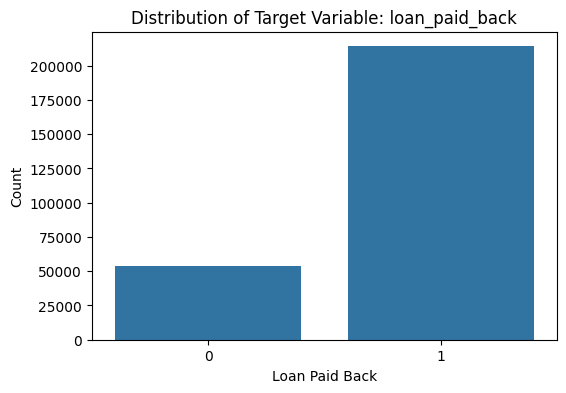

In [46]:
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_paid_back', data=df)
plt.title('Distribution of Target Variable: loan_paid_back')
plt.xlabel('Loan Paid Back')
plt.ylabel('Count')
plt.show()

In [5]:
df['default'] = 1 - df['loan_paid_back']

In [8]:
num_cols = ["annual_income", "debt_to_income_ratio", "credit_score", "loan_amount", "interest_rate"]
cat_cols = ["gender","marital_status","education_level","employment_status","loan_purpose","grade_subgrade"]

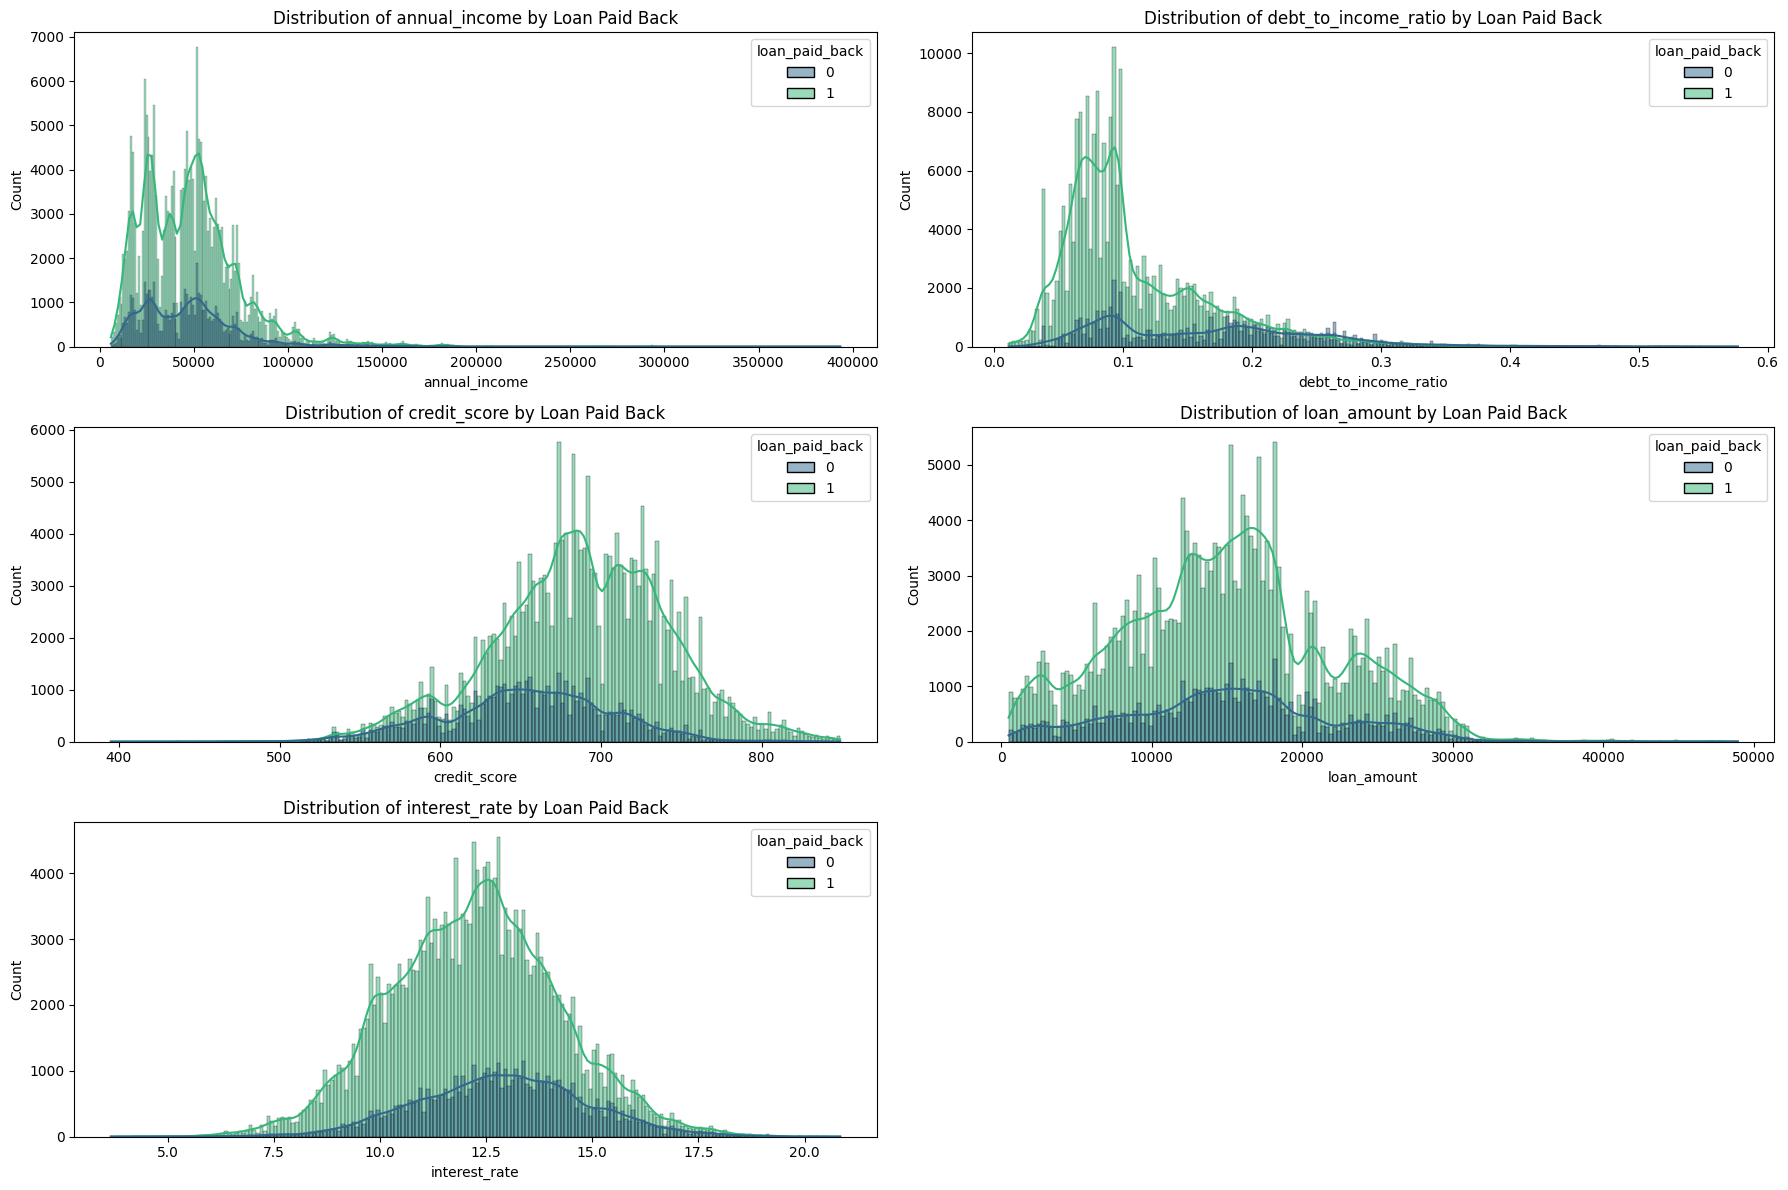

In [48]:
plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols):
    plt.subplot(3, 2, i + 1)
    sns.histplot(data=df, x=col, hue='loan_paid_back', kde=True, palette='viridis')
    plt.title(f'Distribution of {col} by Loan Paid Back')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

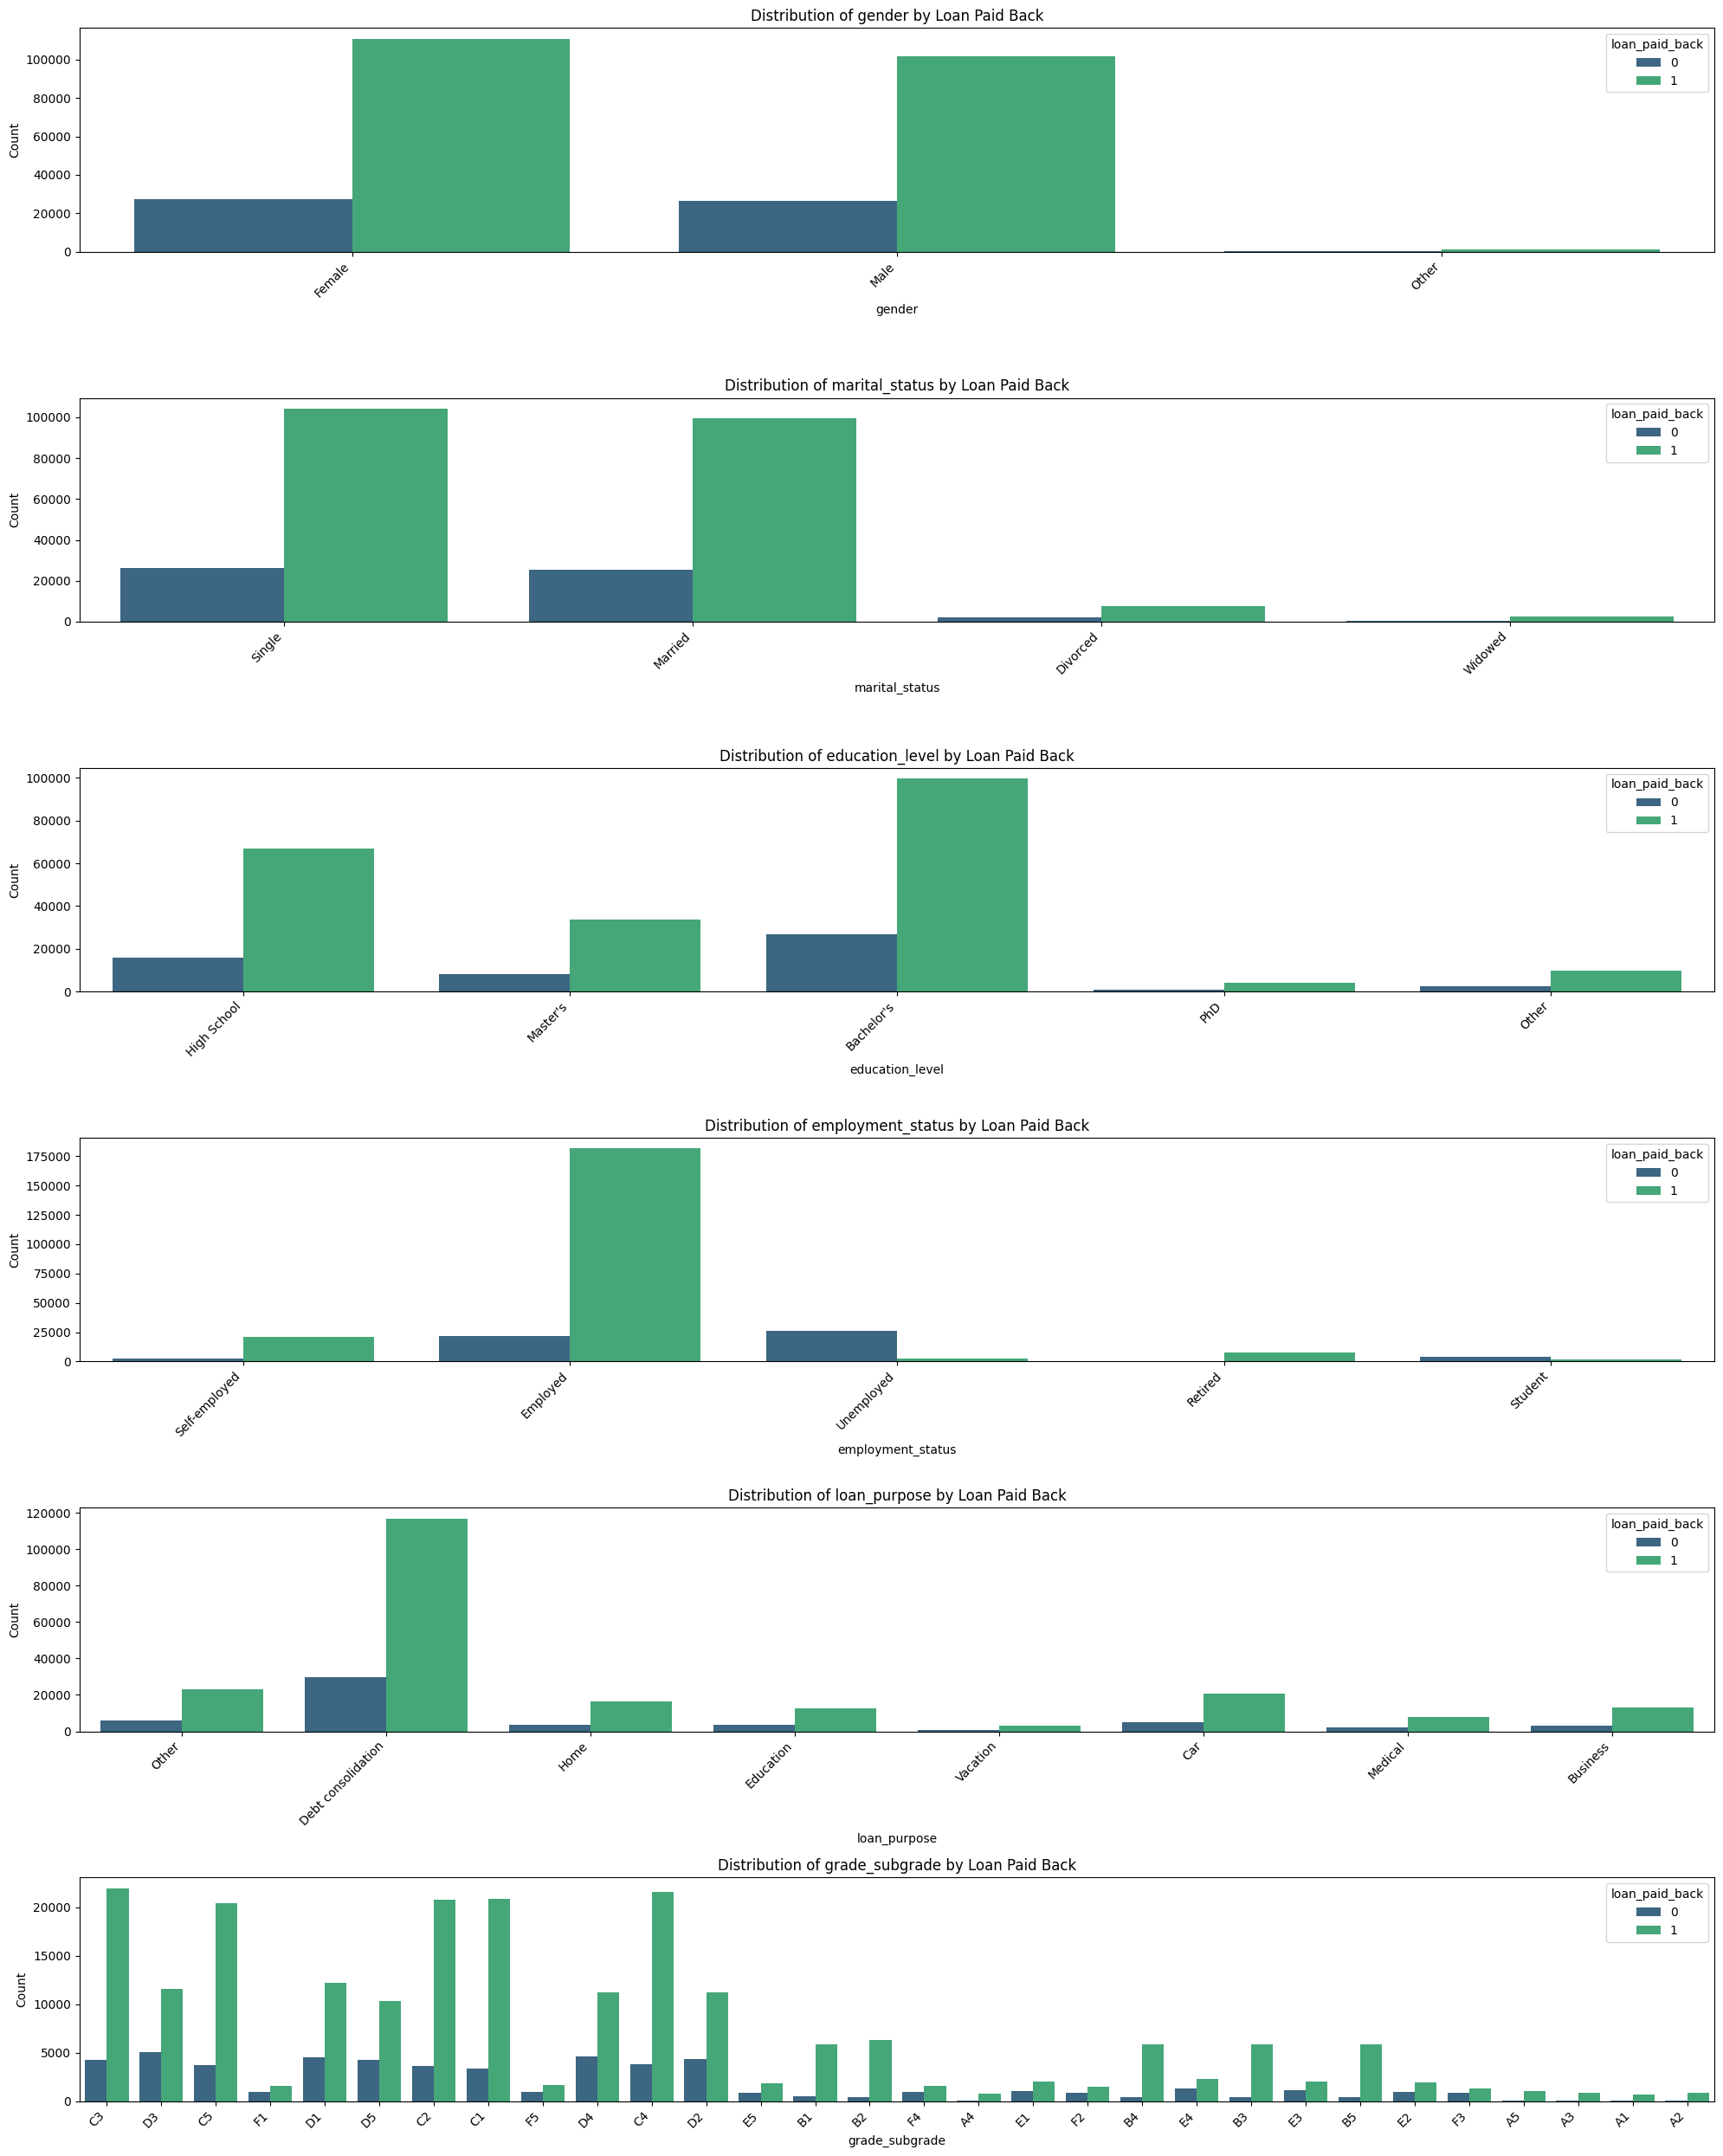

In [49]:
plt.figure(figsize=(20, 25))
for i, col in enumerate(cat_cols):
    plt.subplot(len(cat_cols), 1, i + 1) # Arrange plots vertically for better readability
    sns.countplot(data=df, x=col, hue='loan_paid_back', palette='viridis')
    plt.title(f'Distribution of {col} by Loan Paid Back')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

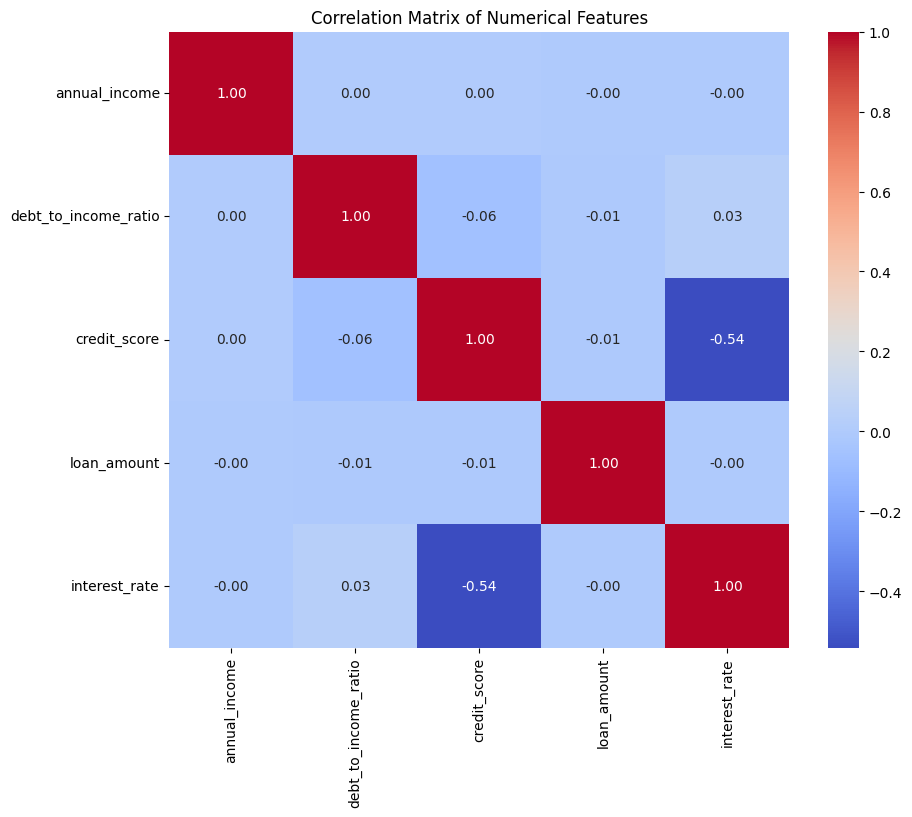

In [50]:
correlation_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [9]:
def add_features(X):
    X = X.copy()
    eps = 1e-6
    X["loan_to_income"] = X["loan_amount"] / (X["annual_income"] + eps)
    X["risk_cost"] = X["loan_amount"] * X["interest_rate"]
    X["log_income"] = np.log(X["annual_income"] + 1)
    X["log_loan"] = np.log(X["loan_amount"] + 1)
    return X


In [10]:
eng_cols = ["loan_to_income", "risk_cost", "log_income", "log_loan"]
all_num_cols = num_cols + eng_cols

In [11]:
X = df[num_cols + cat_cols]
X = add_features(X)
y = df["default"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [27]:
numeric_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num",numeric_transformer,all_num_cols),
        ("cat",categorical_transformer,cat_cols)
    ]
)

In [30]:
hgb = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_iter=300,
        random_state=42))
])

In [31]:
hgb.fit(X_train, y_train)
pred_hgb = hgb.predict_proba(X_test)[:,1]
auc_hgb = roc_auc_score(y_test, pred_hgb)
print(f"HGB Test AUC: {auc_hgb:.4f}")

HGB Test AUC: 0.9174


In [45]:
from sklearn.metrics import classification_report

# Convert probabilities to binary predictions using threshold 0.5
y_pred = (pred_hgb >= 0.5).astype(int)

report = classification_report(y_test, y_pred, target_names=["Paid Back", "Default"])
print(report)

              precision    recall  f1-score   support

   Paid Back       0.91      0.98      0.94     42814
     Default       0.90      0.59      0.71     10809

    accuracy                           0.90     53623
   macro avg       0.90      0.79      0.83     53623
weighted avg       0.90      0.90      0.90     53623



Confusion Matrix:
 [[42095   719]
 [ 4401  6408]]


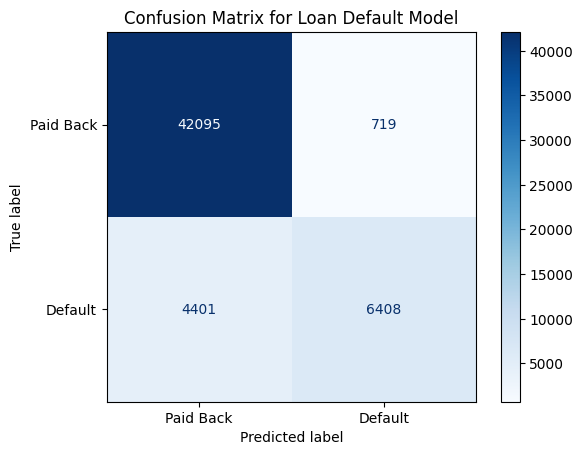

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (pred_hgb >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Paid Back", "Default"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Loan Default Model")
plt.show()

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, pred_hgb)
auc_score = roc_auc_score(y_test, pred_hgb)

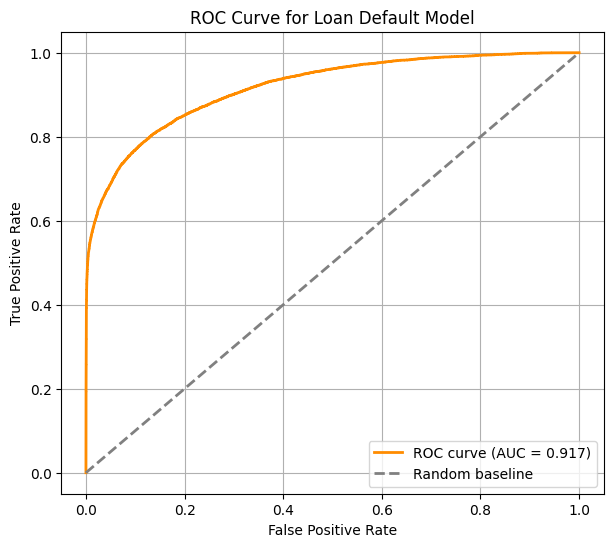

In [37]:
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--", label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Loan Default Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**SUBGROUP ANALYSIS**

In [53]:
# Education-level AUCs
edu_aucs = (
    test.groupby("education_level")
        .apply(lambda g: roc_auc_score(g["y_true"], g["p"]) if g["y_true"].nunique() == 2 else np.nan)
        .sort_values(ascending=False)
)
print("\nAUC by education_level:\n", edu_aucs)

# Loan-purpose AUCs
purpose_aucs = (
    test.groupby("loan_purpose")
        .apply(lambda g: roc_auc_score(g["y_true"], g["p"]) if g["y_true"].nunique() == 2 else np.nan)
        .dropna()
        .sort_values(ascending=False)
)
print("\nTop 3 loan_purpose AUCs:\n", purpose_aucs.head(3))
print("\nBottom 3 loan_purpose AUCs:\n", purpose_aucs.tail(3))


AUC by education_level:
 education_level
PhD            0.919821
Bachelor's     0.919444
Other          0.917642
High School    0.916563
Master's       0.912070
dtype: float64

Top 3 loan_purpose AUCs:
 loan_purpose
Education    0.931508
Vacation     0.921684
Car          0.919372
dtype: float64

Bottom 3 loan_purpose AUCs:
 loan_purpose
Business    0.915281
Home        0.912325
Medical     0.904514
dtype: float64


/tmp/ipython-input-1908397957.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: roc_auc_score(g["y_true"], g["p"]) if g["y_true"].nunique() == 2 else np.nan)
/tmp/ipython-input-1908397957.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: roc_auc_score(g["y_true"], g["p"]) if g["y_true"].nunique() == 2 else np.nan)
